# Figure 1: topography and climatologies
conda env: new `phd_v3`, old `work` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
# seasons = ['Annual', 'DJFMA', 'JJAS']
seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

var_list = ['tas', 'snc', 'pr']

## Load topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load obs

In [4]:
obs_clim_regrid = [None] * len(var_list)

In [5]:
obs = xr.open_dataset('/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc').sel(
    time=period, lat=latlim_ext, lon=lonlim_ext).tmp

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

temp = []
for season in seasons:
    temp.append(
        u.clim(obs, calendar=obs.time.encoding['calendar'], season=season)
    )

# Compute climatology and annual cycle
obs_clim = xr.combine_nested(temp, concat_dim='season')

regridder = xe.Regridder(obs_clim, elevation, 'bilinear', periodic=False, reuse_weights=True)
obs_clim_regrid[0] = regridder(obs_clim)

Reuse existing file: bilinear_70x120_35x60.nc


In [6]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)
with xr.set_options(keep_attrs=True): # Get the snc variable, keep only land data and convert to %
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100   
obs.attrs['units'] = '%'
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

temp = []
for season in seasons:
    temp.append(
        u.clim(obs, calendar='standard', season=season)
    )

# Compute climatology and annual cycle
obs_clim = xr.combine_nested(temp, concat_dim='season')

# Because obs are not global (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs_clim, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
obs_clim_regrid[1] = regridder(obs_clim)

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Reuse existing file: bilinear_88x88_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [7]:
obs_V1101 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip
obs_V1101_EXR1 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip

obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = (xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')).sel(time=period)

# Resamble data per month (from per day)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

temp = []
for season in seasons:
    temp.append(
        u.clim(obs, calendar='standard', season=season)
    )

# Compute climatology and annual cycle
obs_clim = xr.combine_nested(temp, concat_dim='season')

regridder = xe.Regridder(obs_clim, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
obs_clim_regrid[2] = regridder(obs_clim)

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Reuse existing file: bilinear_140x180_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [8]:
obs_clim = xr.concat(obs_clim_regrid, pd.Index(var_list, name='var'))

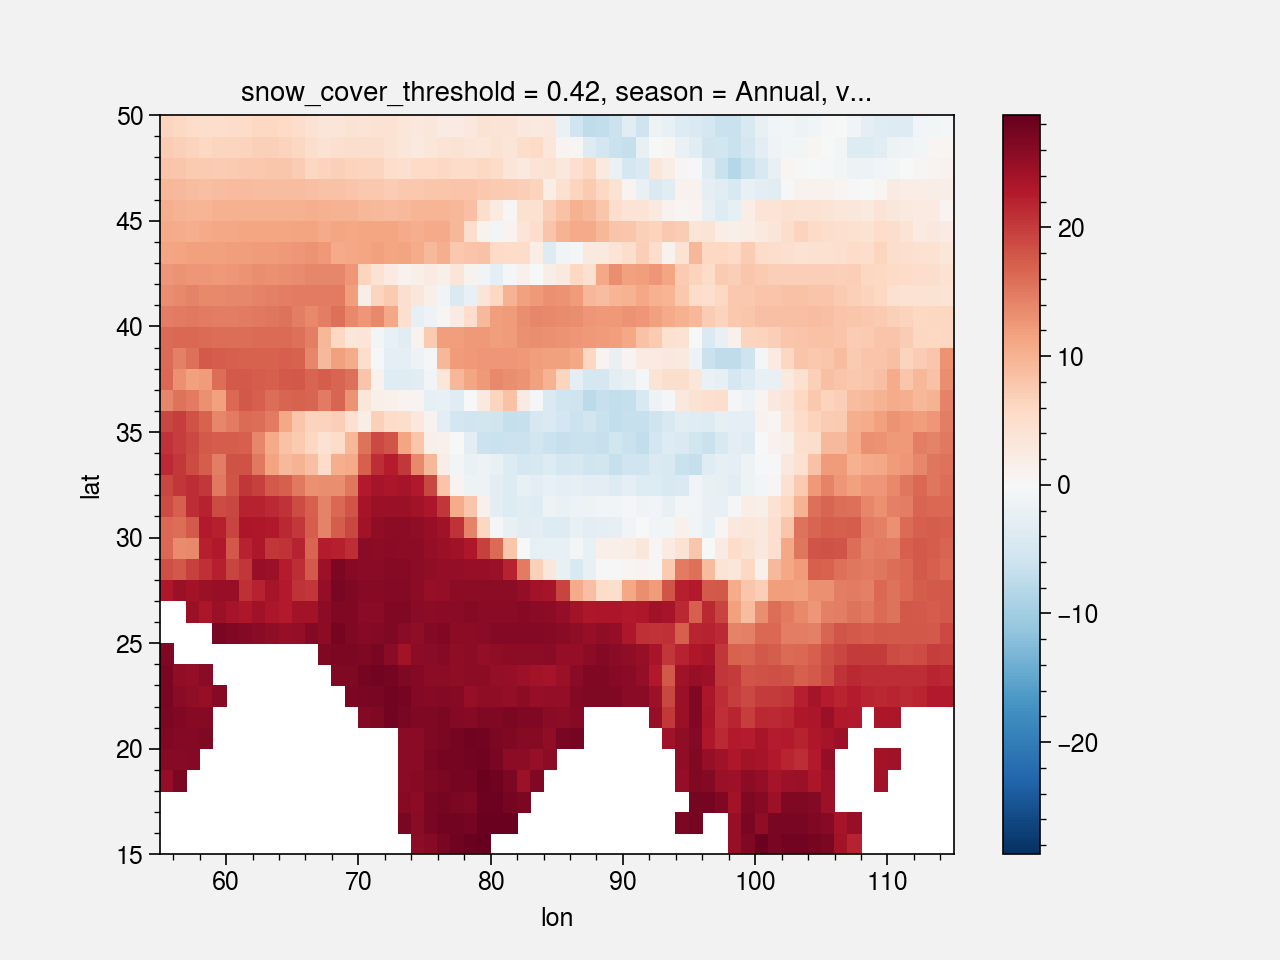

In [50]:
obs_clim.sel(var='tas')[0].plot()

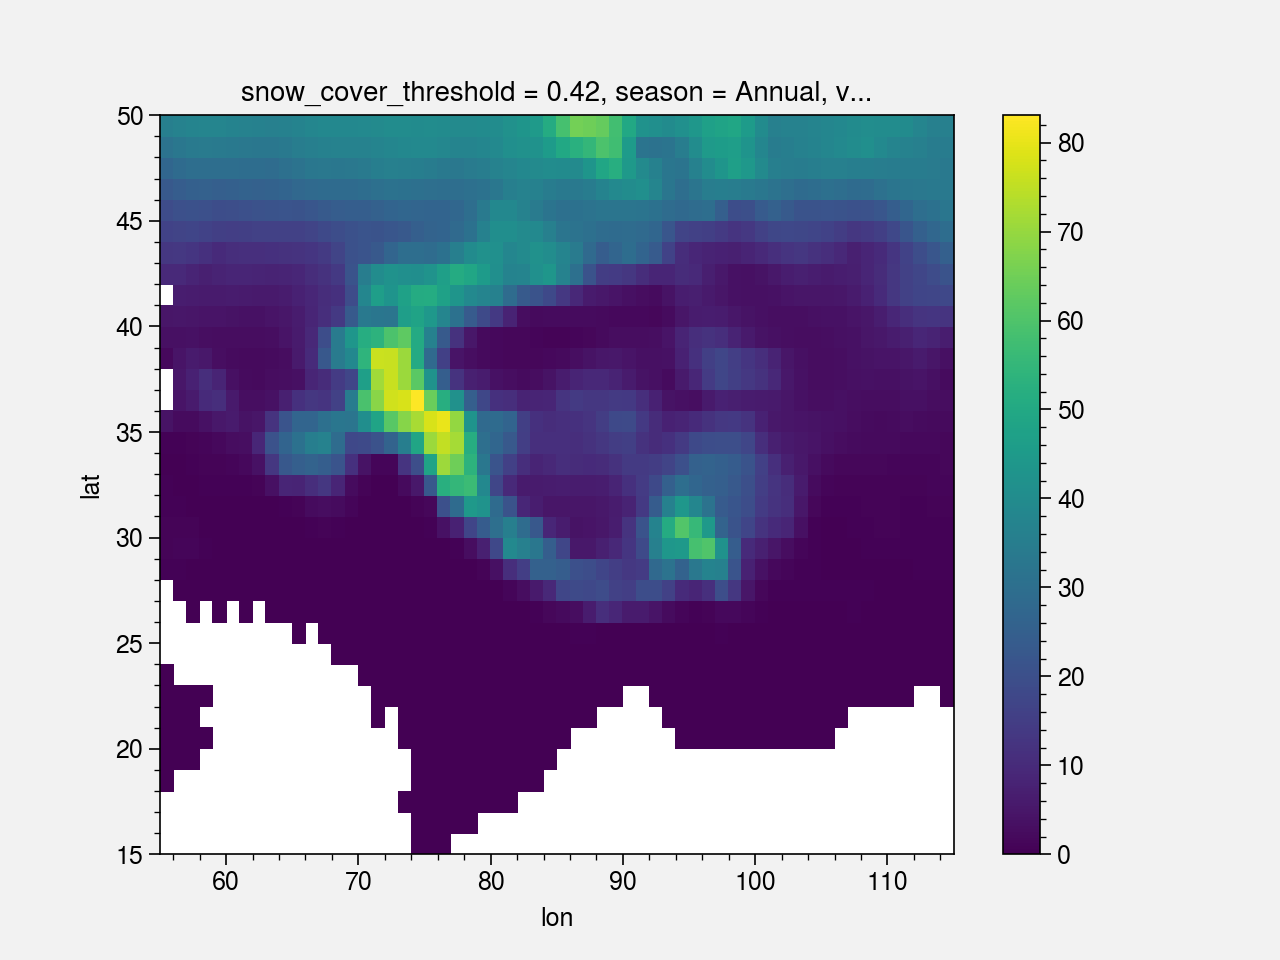

In [51]:
obs_clim.sel(var='snc')[0].plot()

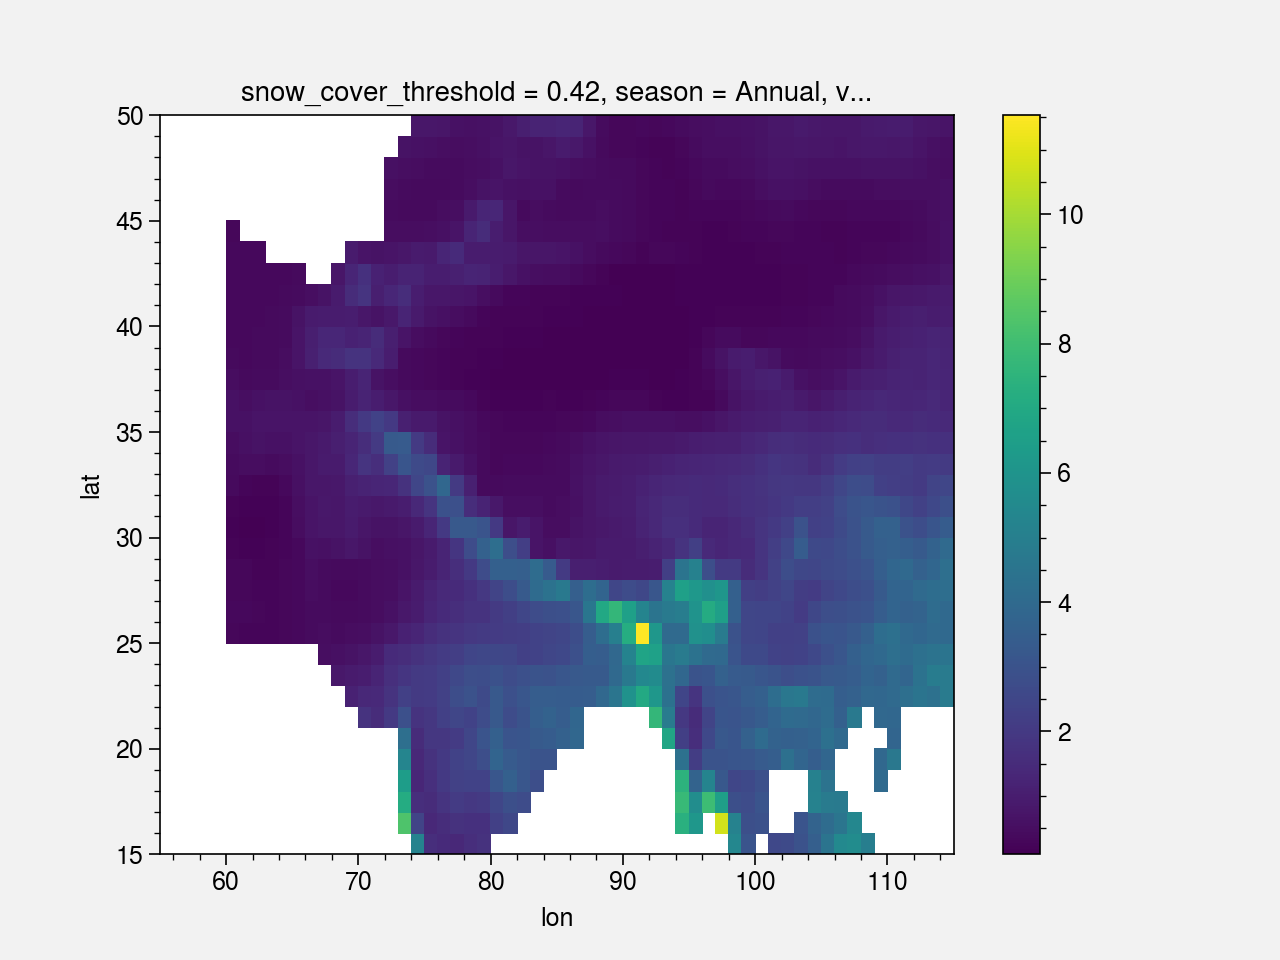

In [52]:
obs_clim.sel(var='pr')[0].plot()

## Load models

In [41]:
%%time

list_models = u.get_model_names()
list_models = list_models[:]
# list_models = ['EC-Earth3']

# Create empty lists for storing results before to concatenate them (for models + ensemble mean and seasons)
# Be carefull with *, see https://snakify.org/fr/lessons/two_dimensional_lists_arrays/#section_2
model_clim_list = [[[None]*len(list_models) for i in range(len(seasons))] for j in range(len(var_list))]

for i_var, var in enumerate(var_list):
    print(var)
    
    table = u.get_table(var)
    label, units, levels, cmap, extend, \
        levels_diff, cmap_diff, extend_diff, \
        levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
    
    for i_model, model in enumerate(list_models):
        print(model + ' ('+str(i_model+1)+'/'+str(len(list_models))+')')
        institute, grid, realization, calendar = u.get_model_infos(model, var)
        ds = xr.open_mfdataset(
            '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
            combine='by_coords').sel(time=period, lat=latlim_ext, lon=lonlim_ext)[var]

        # Check if the time steps are ok
        np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, ds.time.size)

        #################################################################################
        
        # tas (K -> °C)
        if var == 'tas':
            ds -= 273.15
        
        # snc (0-1 to % when needed and take out wrong values)
        elif var == 'snc':
             # Some models have values between 0 and 1 even if units in %    
            if ds.max().values <= 1.1:
                ds = ds*100
            # Some models have wrong values (+-0.1 for numeric precision)
            ds = ds.where( (ds >= -0.1) & (ds <= 100.1) )
        
        # pr (mm/s -> mm/day)
        elif var == 'pr':
            ds = ds * 86400

        #################################################################################

        # Print resolution and save it
        lat = (ds.lat[1] - ds.lat[0]).values; lon = (ds.lon[1] - ds.lon[0]).values
        print(str(lon.round(1))+'°x'+str(lat.round(1))+'°')

        # Make regridder
        regridder = xe.Regridder(ds, elevation, 'bilinear', periodic=False, reuse_weights=True)


        # Compute metrics on the only HMA zone
        for i_season, season in enumerate(seasons):
            # Compute climatology
            model_clim = u.clim(ds, calendar=calendar, season=season)

            # Regrid towards elevation grid 1°x1°
            model_clim_regrid = regridder(model_clim)

            model_clim_list[i_var][i_season][i_model] = model_clim_regrid.load()

        print('\n')

tas
BCC-CSM2-MR (1/26)
1.1°x1.1°
Reuse existing file: bilinear_32x54_35x60.nc


BCC-ESM1 (2/26)
2.8°x2.8°
Reuse existing file: bilinear_13x21_35x60.nc


CAS-ESM2-0 (3/26)
1.4°x1.4°
Reuse existing file: bilinear_24x42_35x60.nc


CESM2 (4/26)


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


1.2°x0.9°
Reuse existing file: bilinear_37x49_35x60.nc


CESM2-FV2 (5/26)


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2.5°x1.9°
Reuse existing file: bilinear_18x25_35x60.nc


CESM2-WACCM (6/26)


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


1.2°x0.9°
Reuse existing file: bilinear_37x49_35x60.nc


CESM2-WACCM-FV2 (7/26)


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2.5°x1.9°
Reuse existing file: bilinear_18x25_35x60.nc


CNRM-CM6-1 (8/26)
1.4°x1.4°
Reuse existing file: bilinear_25x42_35x60.nc


CNRM-CM6-1-HR (9/26)
0.5°x0.5°
Reuse existing file: bilinear_70x121_35x60.nc


CNRM-ESM2-1 (10/26)
1.4°x1.4°
Reuse existing file: bilinear_25x42_35x60.nc


CanESM5 (11/26)
2.8°x2.8°
Reuse existing file: bilinear_13x21_35x60.nc


GFDL-CM4 (12/26)
1.2°x1.0°
Reuse existing file: bilinear_35x48_35x60.nc


GISS-E2-1-G (13/26)
2.5°x2.0°
Reuse existing file: bilinear_18x24_35x60.nc


GISS-E2-1-H (14/26)
2.5°x2.0°
Reuse existing file: bilinear_18x24_35x60.nc


HadGEM3-GC31-LL (15/26)
1.9°x1.2°
Reuse existing file: bilinear_28x32_35x60.nc


HadGEM3-GC31-MM (16/26)
0.8°x0.6°
Reuse existing file: bilinear_63x72_35x60.nc


IPSL-CM6A-LR (17/26)
2.5°x1.3°
Reuse existing file: bilinear_28x25_35x60.nc


MIROC-ES2L (18/26)
2.8°x2.8°
Reuse existing file: bilinear_13x21_35x60.nc


MIROC6 (19/26)
1.4°x1.4°
Reuse existing file: bilinear_25x42_35x60.nc


MPI-ESM1-2-HR (20/26)
0

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'snc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


1.2°x0.9°
Reuse existing file: bilinear_37x49_35x60.nc


CESM2-FV2 (5/26)


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'snc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2.5°x1.9°
Reuse existing file: bilinear_18x25_35x60.nc


CESM2-WACCM (6/26)


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'snc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


1.2°x0.9°
Reuse existing file: bilinear_37x49_35x60.nc


CESM2-WACCM-FV2 (7/26)


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'snc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2.5°x1.9°
Reuse existing file: bilinear_18x25_35x60.nc


CNRM-CM6-1 (8/26)
1.4°x1.4°
Reuse existing file: bilinear_25x42_35x60.nc


CNRM-CM6-1-HR (9/26)
0.5°x0.5°
Reuse existing file: bilinear_70x121_35x60.nc


CNRM-ESM2-1 (10/26)
1.4°x1.4°
Reuse existing file: bilinear_25x42_35x60.nc


CanESM5 (11/26)
2.8°x2.8°
Reuse existing file: bilinear_13x21_35x60.nc


GFDL-CM4 (12/26)
1.2°x1.0°
Reuse existing file: bilinear_35x48_35x60.nc


GISS-E2-1-G (13/26)
2.5°x2.0°
Reuse existing file: bilinear_18x24_35x60.nc


GISS-E2-1-H (14/26)
2.5°x2.0°
Reuse existing file: bilinear_18x24_35x60.nc


HadGEM3-GC31-LL (15/26)
1.9°x1.2°
Reuse existing file: bilinear_28x32_35x60.nc


HadGEM3-GC31-MM (16/26)
0.8°x0.6°
Reuse existing file: bilinear_63x72_35x60.nc


IPSL-CM6A-LR (17/26)
2.5°x1.3°
Reuse existing file: bilinear_28x25_35x60.nc


MIROC-ES2L (18/26)
2.8°x2.8°
Reuse existing file: bilinear_13x21_35x60.nc


MIROC6 (19/26)
1.4°x1.4°
Reuse existing file: bilinear_25x42_35x60.nc


MPI-ESM1-2-HR (20/26)
0

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


1.2°x0.9°
Reuse existing file: bilinear_37x49_35x60.nc


CESM2-FV2 (5/26)


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2.5°x1.9°
Reuse existing file: bilinear_18x25_35x60.nc


CESM2-WACCM (6/26)


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


1.2°x0.9°
Reuse existing file: bilinear_37x49_35x60.nc


CESM2-WACCM-FV2 (7/26)


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2.5°x1.9°
Reuse existing file: bilinear_18x25_35x60.nc


CNRM-CM6-1 (8/26)
1.4°x1.4°
Reuse existing file: bilinear_25x42_35x60.nc


CNRM-CM6-1-HR (9/26)
0.5°x0.5°
Reuse existing file: bilinear_70x121_35x60.nc


CNRM-ESM2-1 (10/26)
1.4°x1.4°
Reuse existing file: bilinear_25x42_35x60.nc


CanESM5 (11/26)
2.8°x2.8°
Reuse existing file: bilinear_13x21_35x60.nc


GFDL-CM4 (12/26)
1.2°x1.0°
Reuse existing file: bilinear_35x48_35x60.nc


GISS-E2-1-G (13/26)
2.5°x2.0°
Reuse existing file: bilinear_18x24_35x60.nc


GISS-E2-1-H (14/26)
2.5°x2.0°
Reuse existing file: bilinear_18x24_35x60.nc


HadGEM3-GC31-LL (15/26)
1.9°x1.2°
Reuse existing file: bilinear_28x32_35x60.nc


HadGEM3-GC31-MM (16/26)
0.8°x0.6°
Reuse existing file: bilinear_63x72_35x60.nc


IPSL-CM6A-LR (17/26)
2.5°x1.3°
Reuse existing file: bilinear_28x25_35x60.nc


MIROC-ES2L (18/26)
2.8°x2.8°
Reuse existing file: bilinear_13x21_35x60.nc


MIROC6 (19/26)
1.4°x1.4°
Reuse existing file: bilinear_25x42_35x60.nc


MPI-ESM1-2-HR (20/26)
0

In [27]:
i_var = 0
i_season = 0
i_model = 0

# model_clim_list[i_var][i_season][i_model].plot()

## Make multi-model ensemble

In [54]:
temp2 = [None] * len(var_list)
for i, var in enumerate(var_list):
    
    temp = [None] * len(seasons)
    for k, season in enumerate(seasons):
        temp[k] = xr.concat(
            model_clim_list[i][k][:], pd.Index(list_models, name="model"), coords='minimal', compat='override'
        )

    temp2[i] = xr.concat(temp, pd.Index(seasons, name="season"))

multimodel_clim = xr.concat(temp2, pd.Index(var_list, name="var"))

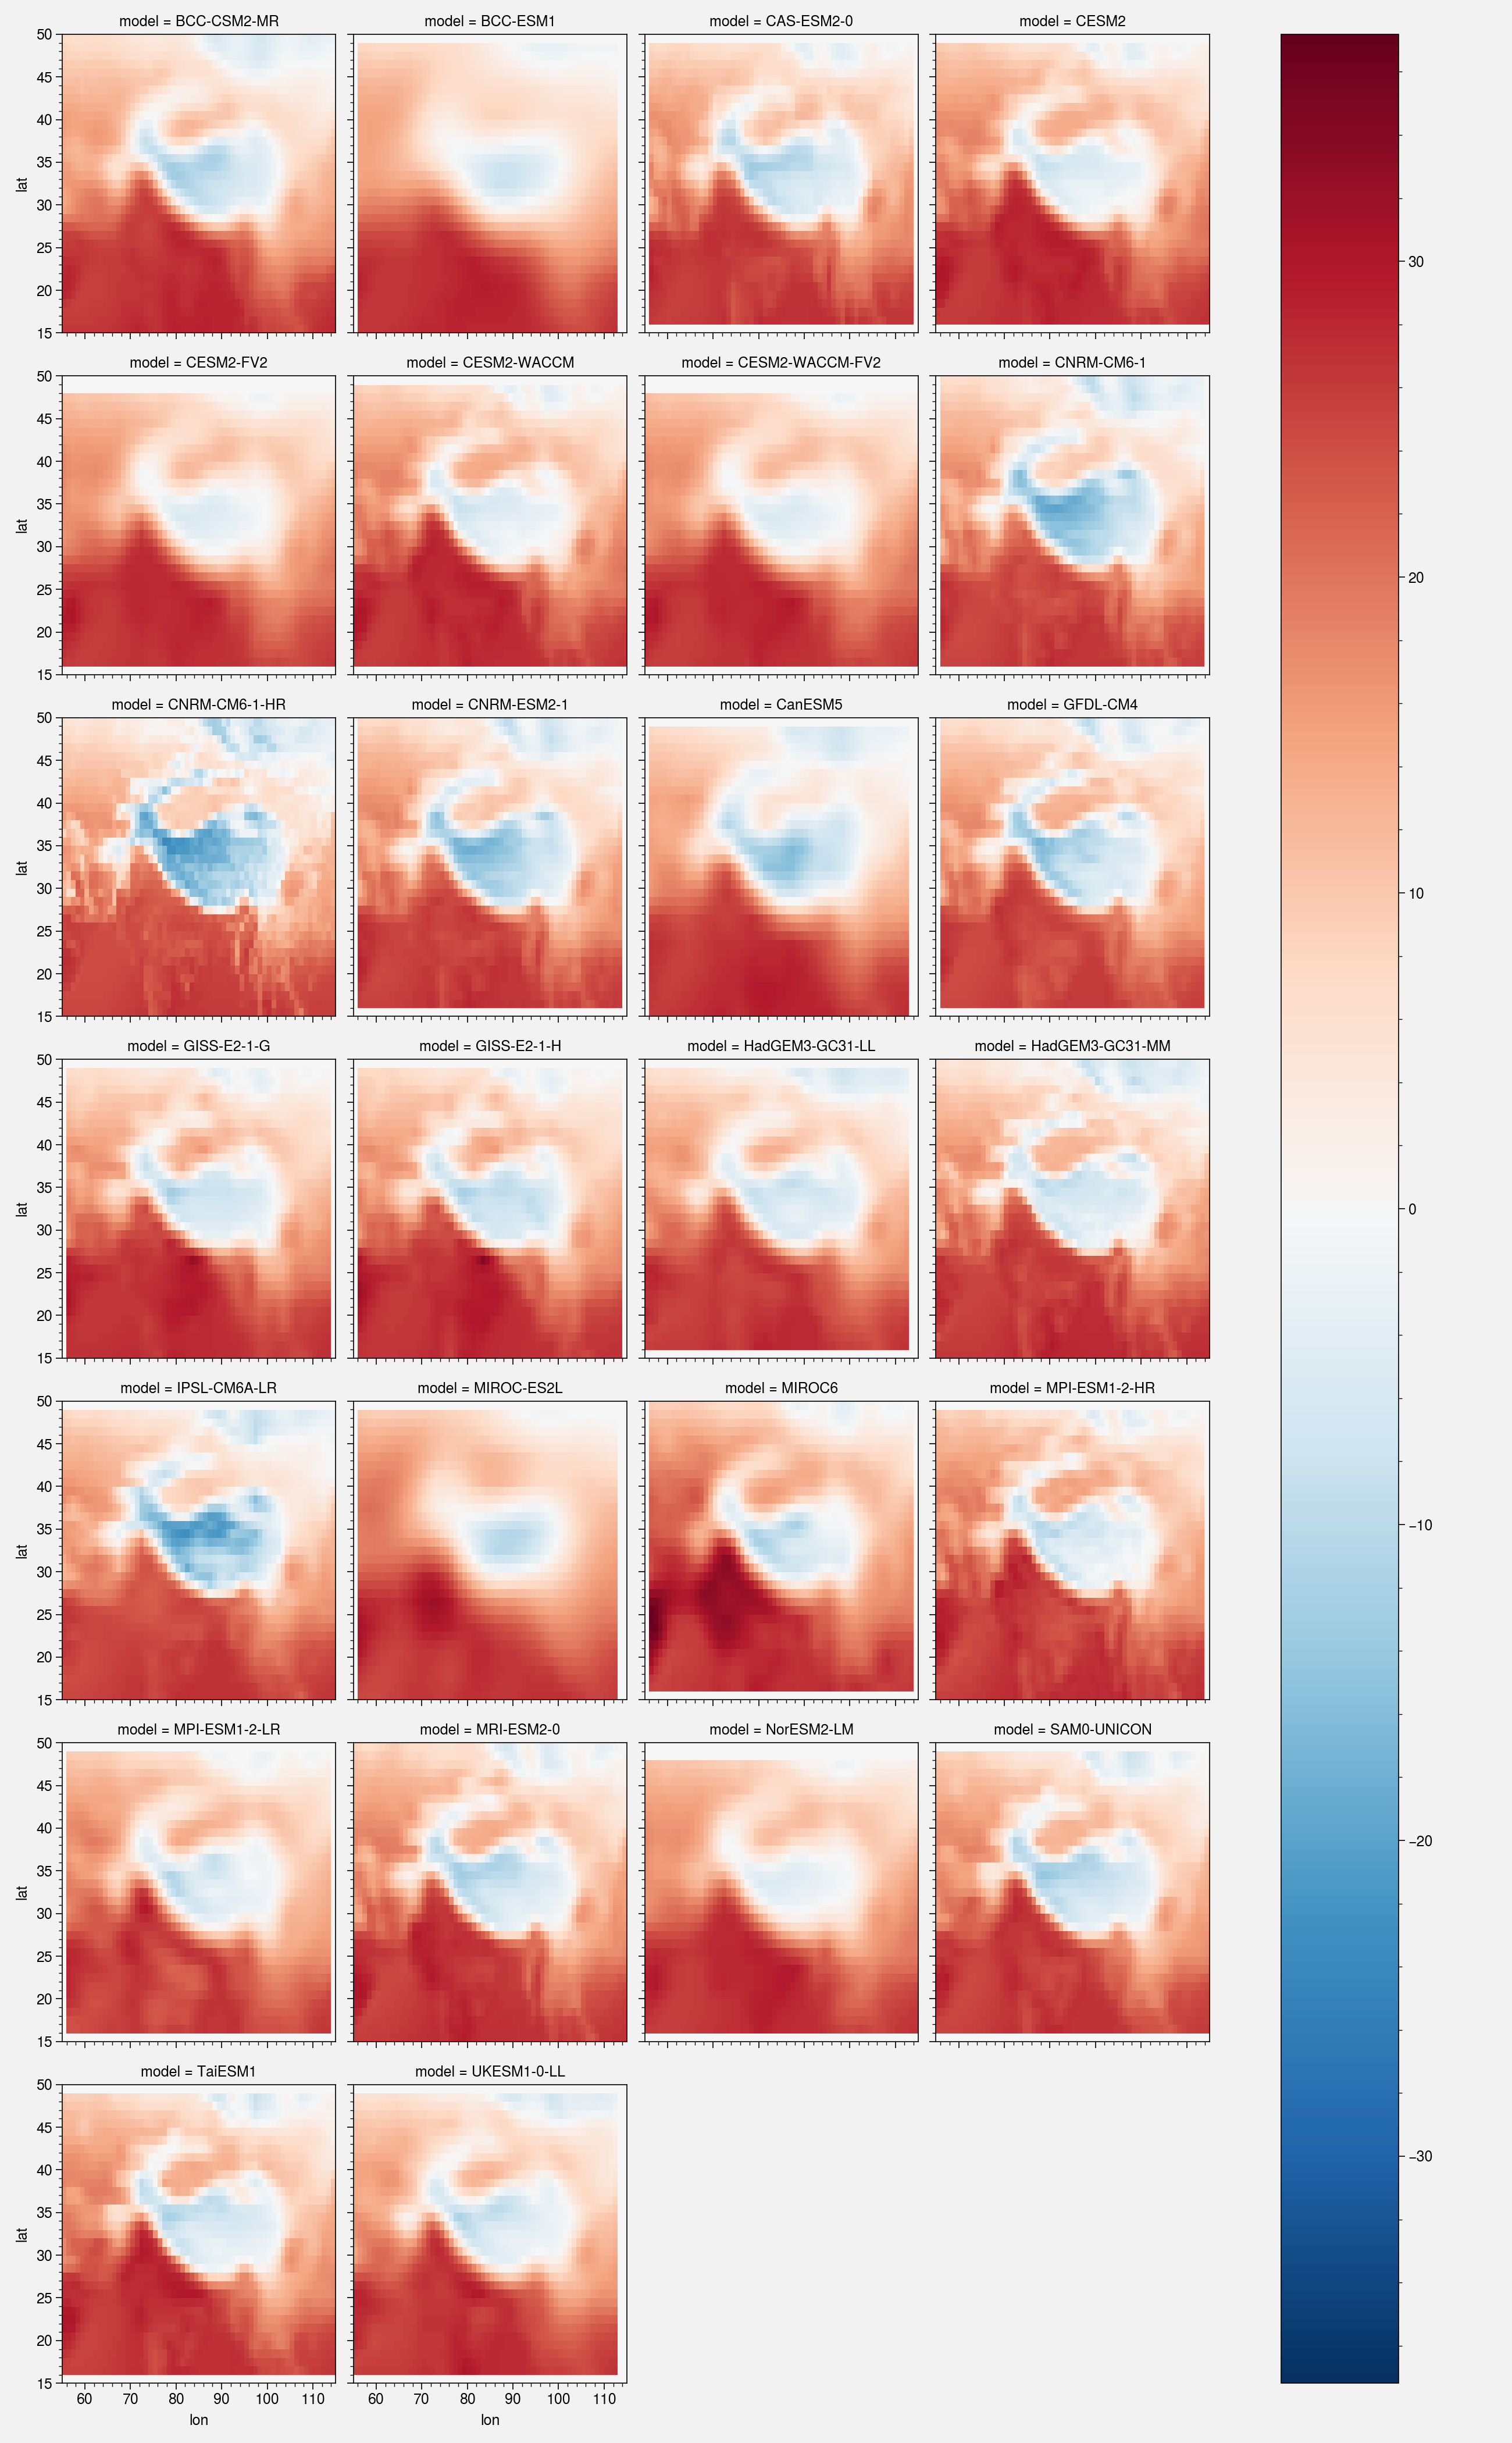

In [55]:
multimodel_clim[0][0].plot(col='model', col_wrap=4)

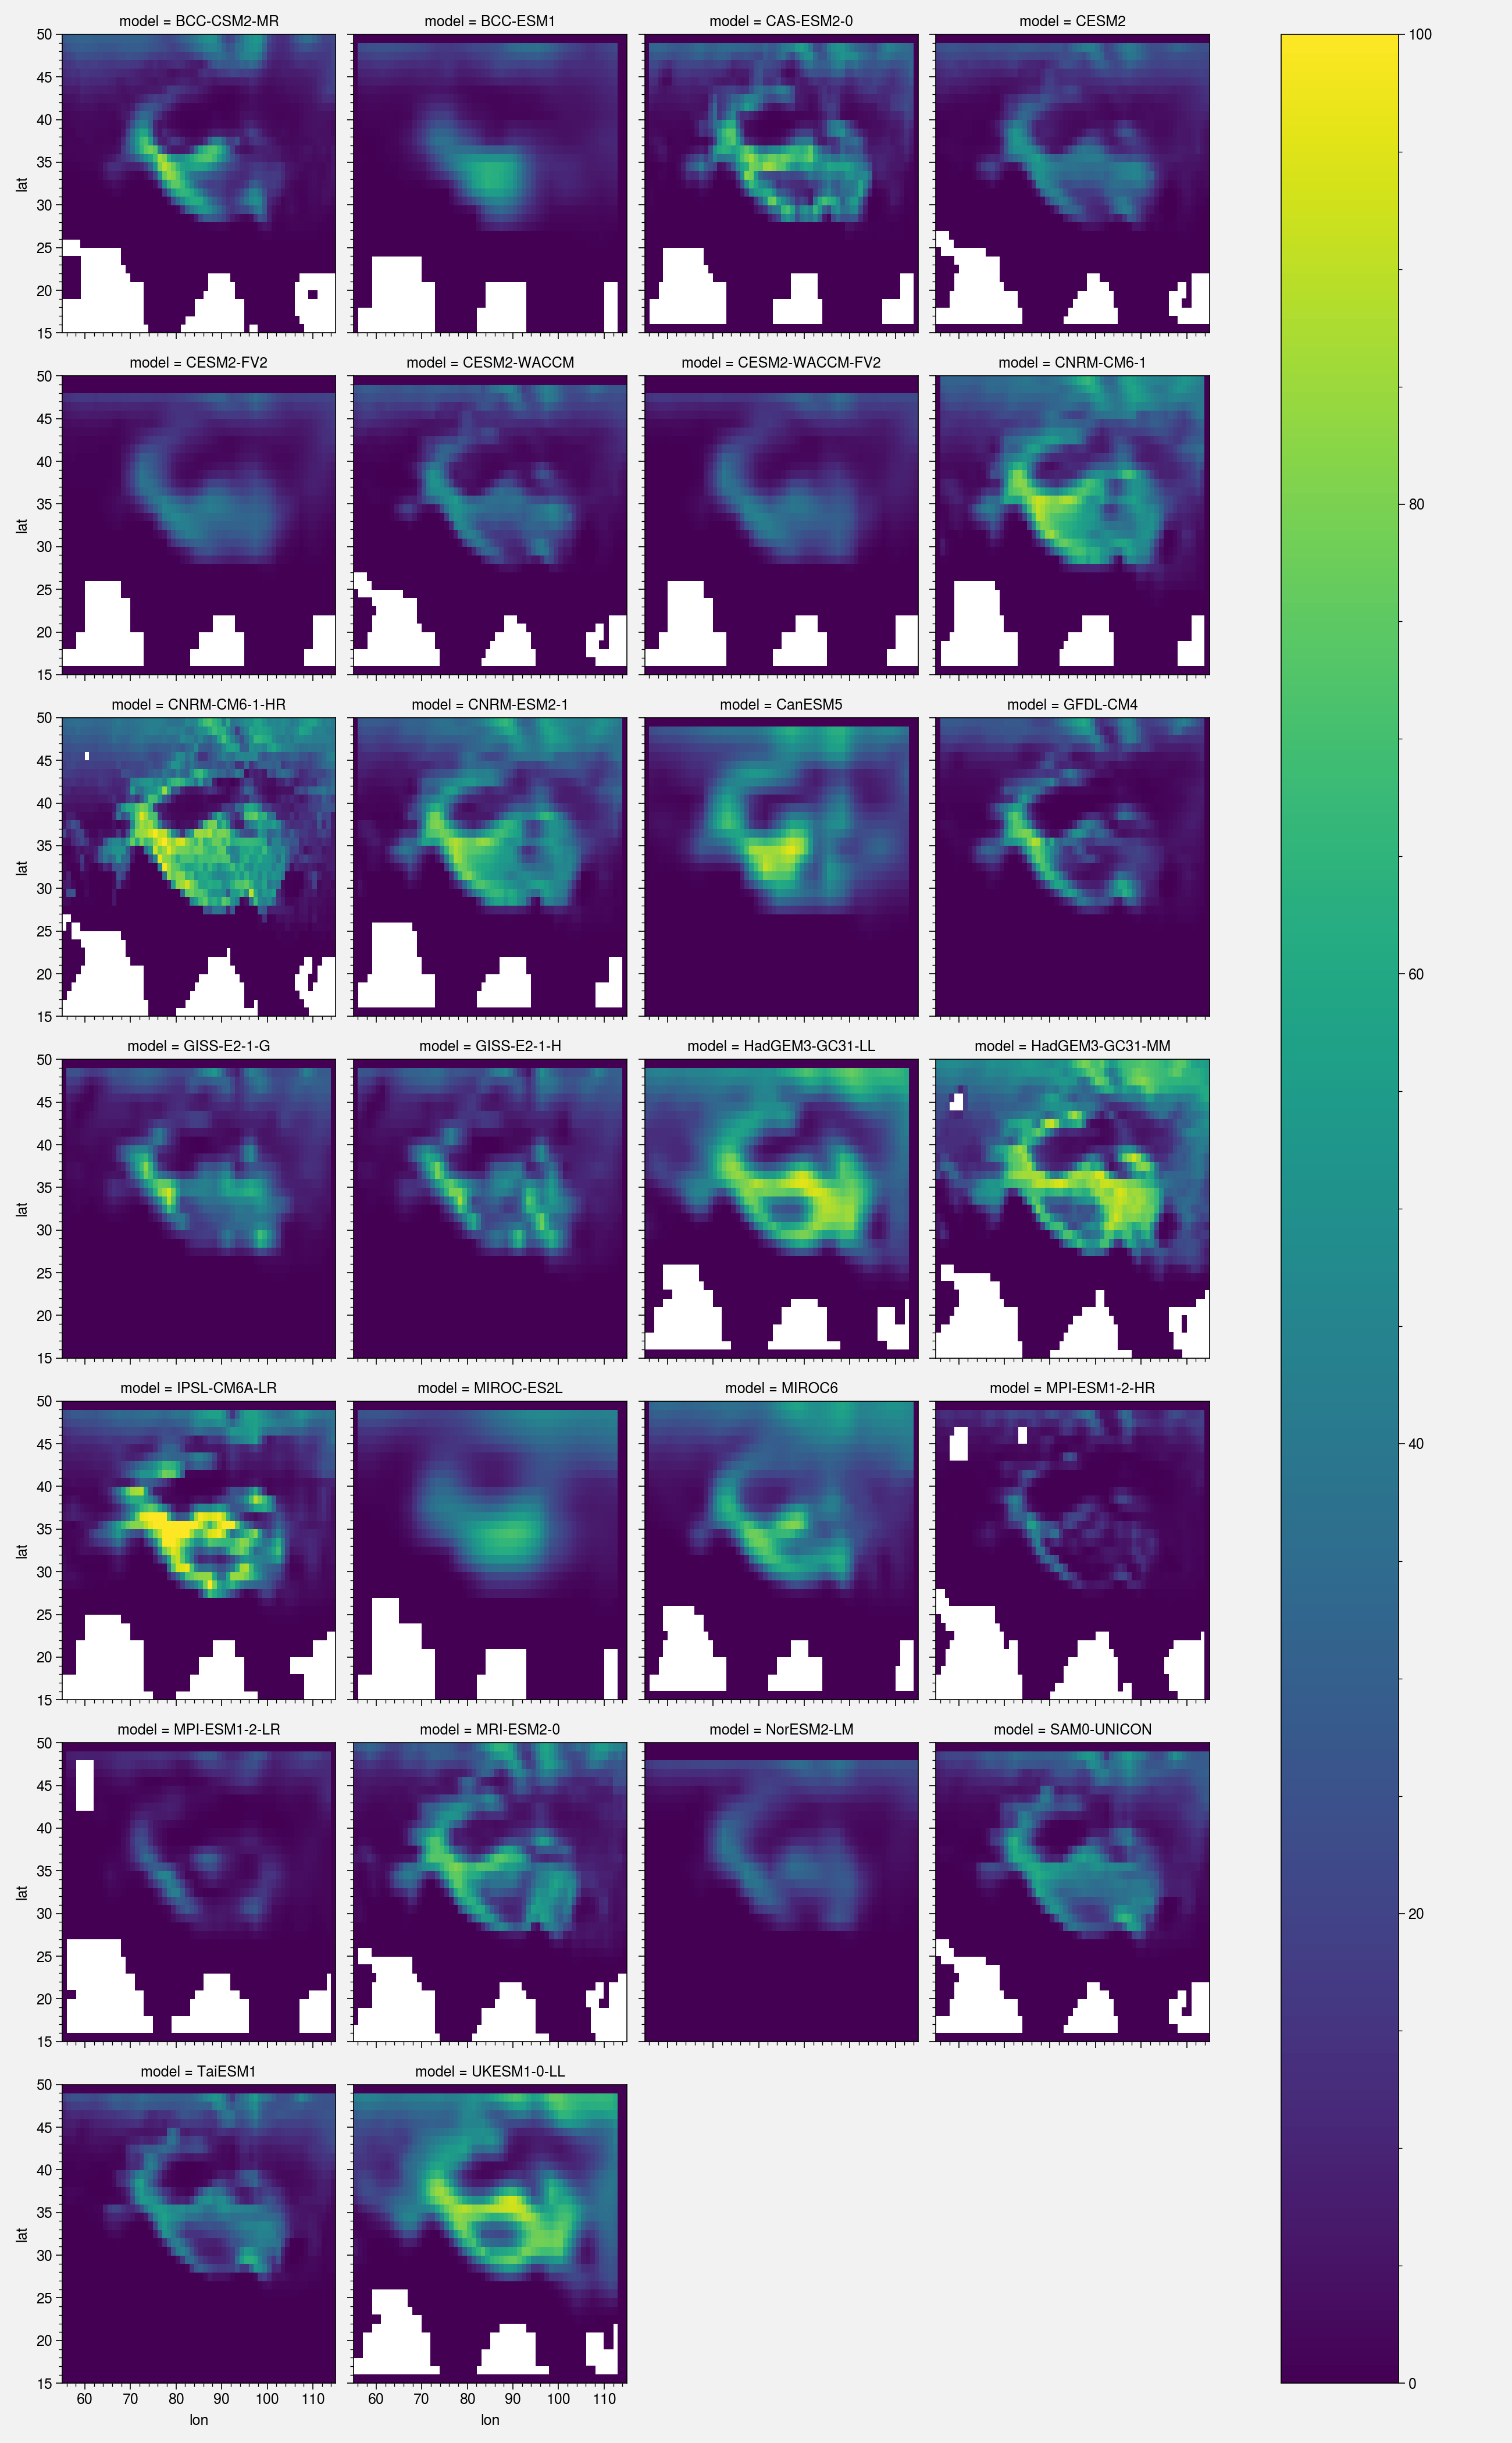

In [56]:
multimodel_clim[1][0].plot(col='model', col_wrap=4)

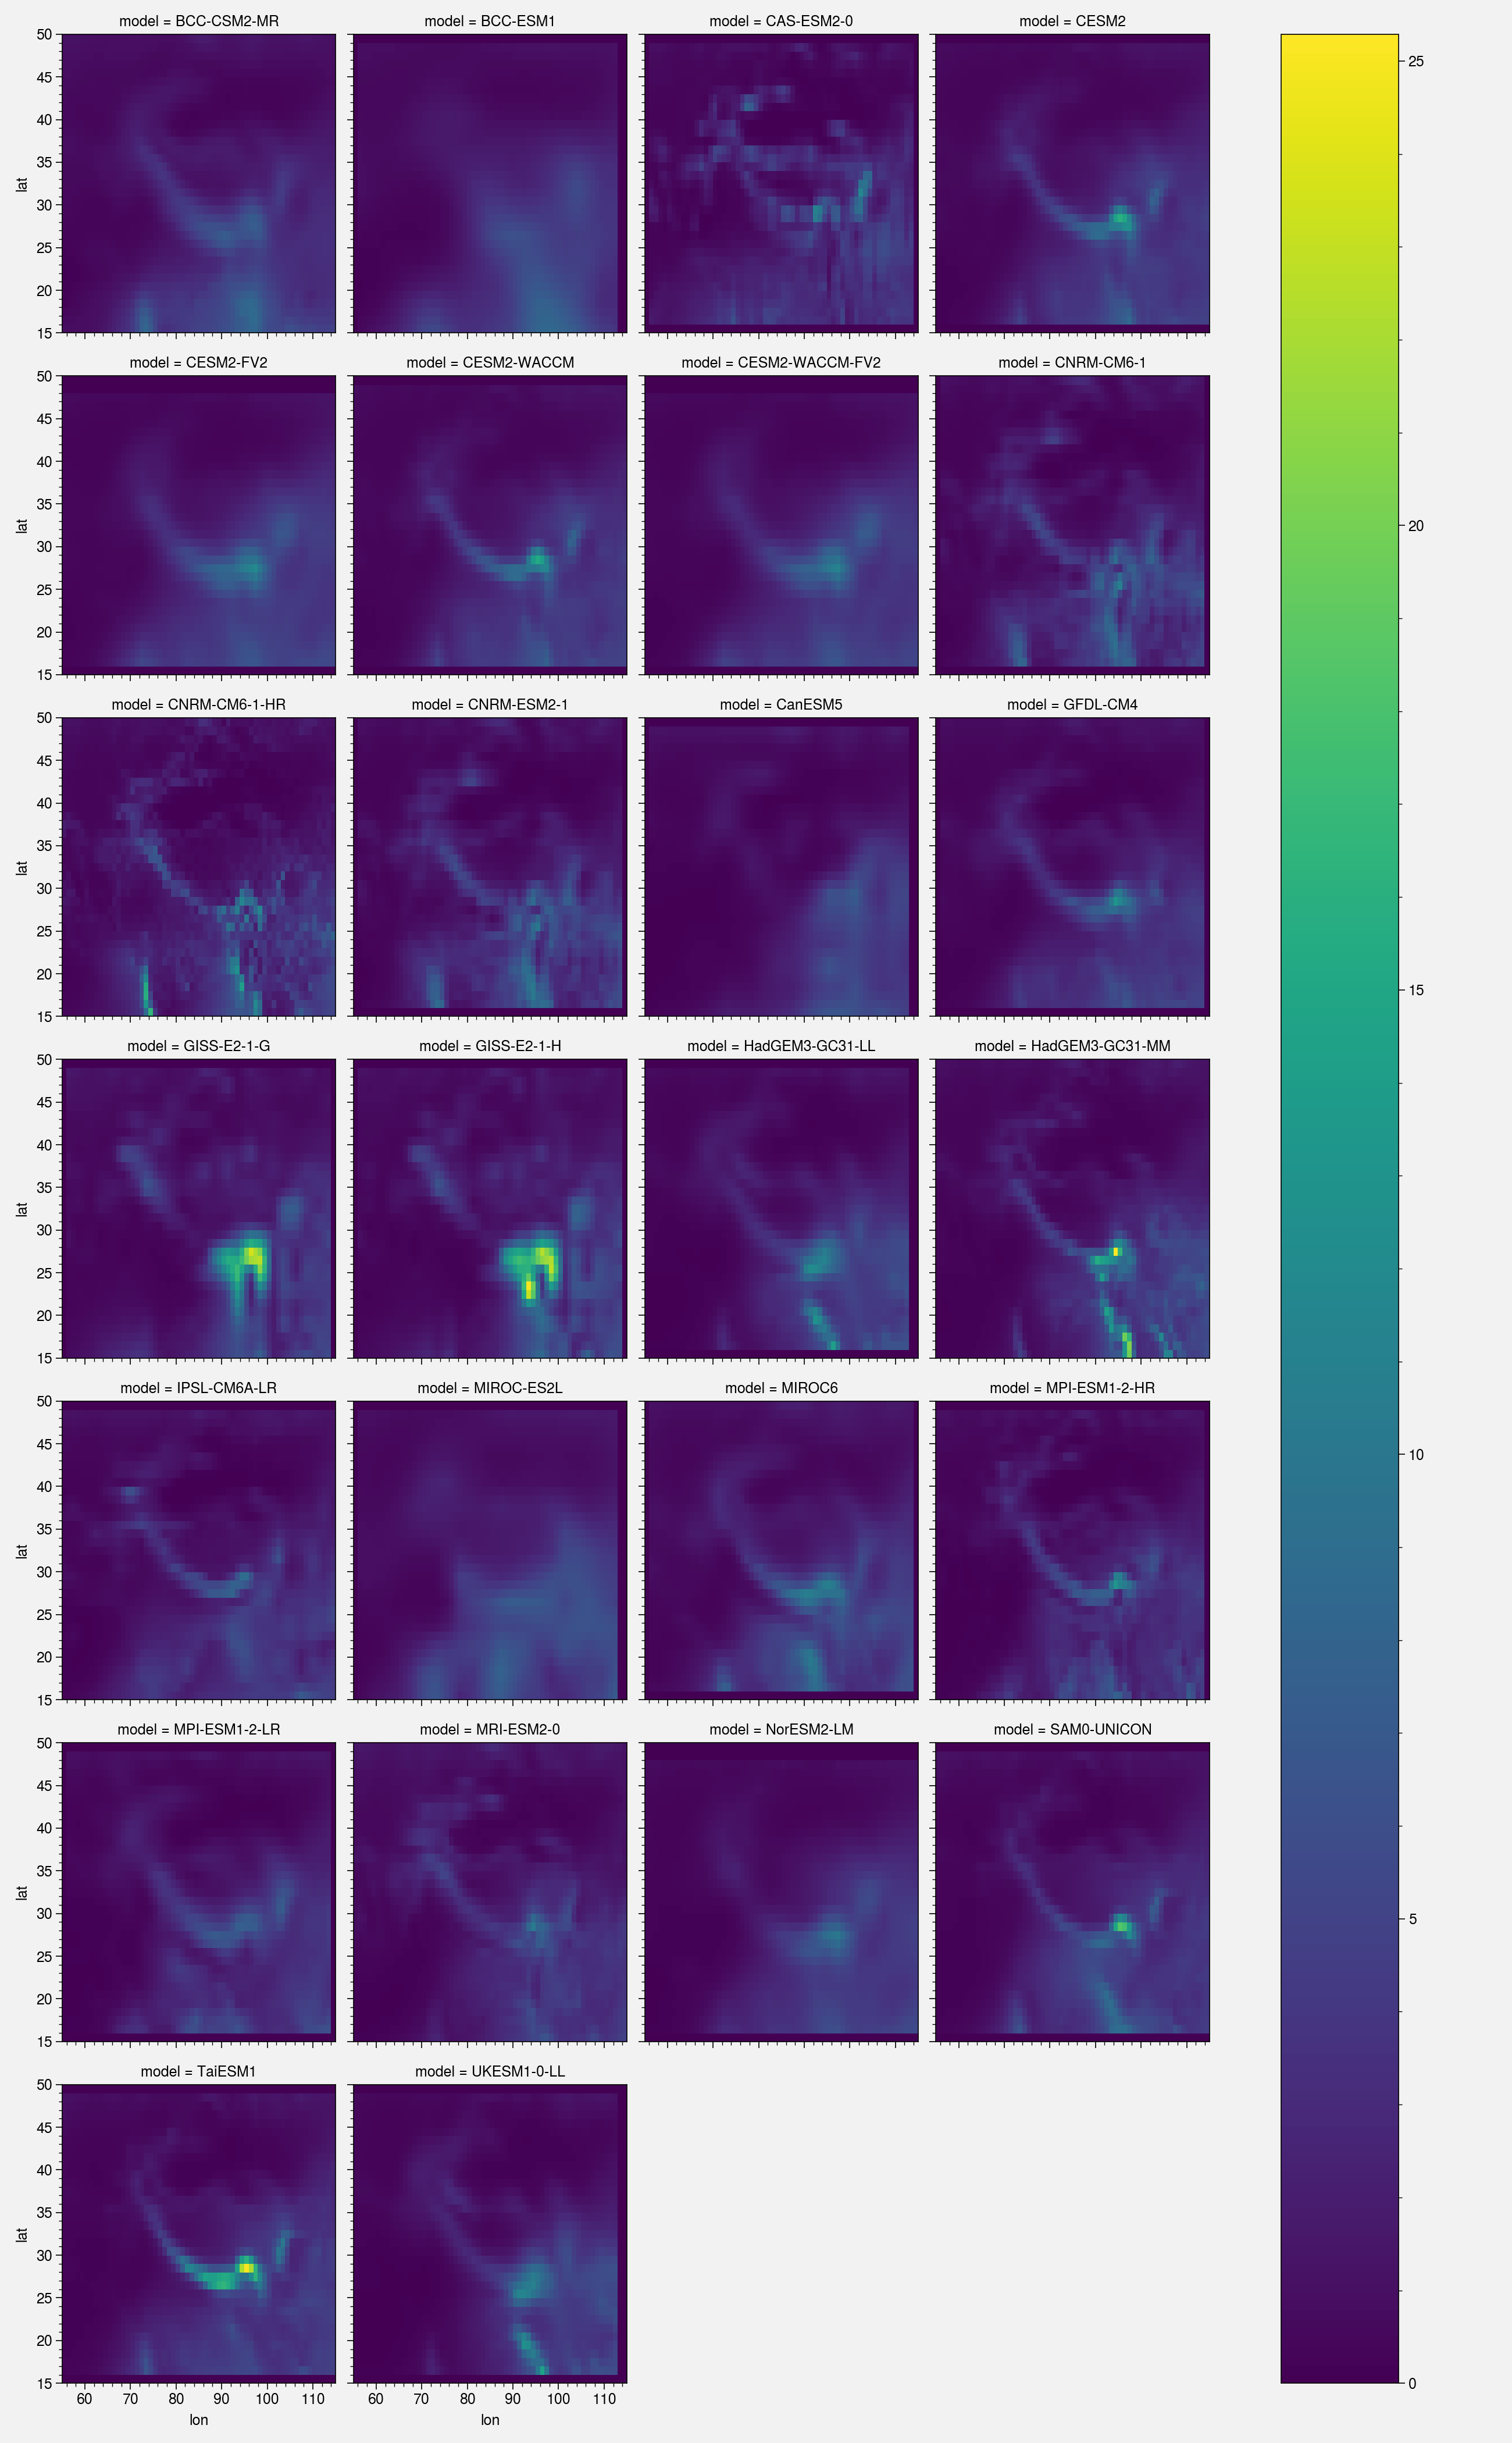

In [57]:
multimodel_clim[2][0].plot(col='model', col_wrap=4)

## Save results

In [58]:
multimodel_clim.to_netcdf(
    'results/multimodel_clim_'+period.start+'-'+period.stop+'.nc'
)

obs_clim.to_netcdf(
    'results/obs_clim_'+period.start+'-'+period.stop+'.nc'
)

## Load results

In [9]:
multimodel_clim = xr.open_dataarray(
    'results/multimodel_clim_'+period.start+'-'+period.stop+'.nc'
)

obs_clim = xr.open_dataarray(
    'results/obs_clim_'+period.start+'-'+period.stop+'.nc'
)

## Get values

In [11]:
obs_clim.sel(lat=latlim, lon=lonlim).where(elevation > 2500).min(dim=('lat','lon'))

<xarray.DataArray (var: 3, season: 1)>
array([[-7.65966525],
       [ 0.52260961],
       [ 0.09797618]])
Coordinates:
    snow_cover_threshold  float32 0.42
  * season                (season) object 'Annual'
  * var                   (var) object 'tas' 'snc' 'pr'

In [25]:
obs_clim.sel(lat=latlim, lon=lonlim).where(elevation > 2500).max(dim=('lat','lon'))

<xarray.DataArray (var: 3, season: 1)>
array([[13.37755024],
       [83.07365004],
       [ 4.13804815]])
Coordinates:
    snow_cover_threshold  float32 0.42
  * season                (season) object 'Annual'
  * var                   (var) object 'tas' 'snc' 'pr'

In [17]:
obs_clim.sel(lat=latlim, lon=lonlim).max(dim=('lat','lon'))

<xarray.DataArray (var: 3, season: 1)>
array([[27.84027458],
       [83.07365004],
       [11.53397562]])
Coordinates:
    snow_cover_threshold  float32 0.42
  * season                (season) object 'Annual'
  * var                   (var) object 'tas' 'snc' 'pr'

In [16]:
u.spatial_average(multimodel_clim.sel(lat=latlim, lon=lonlim).where(elevation > 2500).mean('model'))

<xarray.DataArray (var: 3, season: 1)>
array([[-2.1145392 ],
       [35.88178345],
       [ 2.49794339]])
Coordinates:
    height   float64 2.0
  * season   (season) object 'Annual'
  * var      (var) object 'tas' 'snc' 'pr'

In [14]:
multimodel_clim.sel(lat=latlim, lon=lonlim).where(elevation > 2500).mean('model').min(dim=('lat','lon'))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray (var: 3, season: 1)>
array([[-11.16814264],
       [  3.31831261],
       [  0.60028378]])
Coordinates:
    height   float64 ...
  * season   (season) object 'Annual'
  * var      (var) object 'tas' 'snc' 'pr'

In [18]:
multimodel_clim.sel(lat=latlim, lon=lonlim).where(elevation > 2500).mean('model').max(dim=('lat','lon'))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray (var: 3, season: 1)>
array([[11.93715724],
       [66.80653018],
       [ 9.75885296]])
Coordinates:
    height   float64 ...
  * season   (season) object 'Annual'
  * var      (var) object 'tas' 'snc' 'pr'

In [20]:
multimodel_clim.sel(lat=latlim, lon=lonlim).mean('model').max(dim=('lat','lon'))

<xarray.DataArray (var: 3, season: 1)>
array([[27.50651886],
       [66.80653018],
       [ 9.90748802]])
Coordinates:
    height   float64 2.0
  * season   (season) object 'Annual'
  * var      (var) object 'tas' 'snc' 'pr'

In [ ]:
latlim_TP

## Make final plots (for each season)

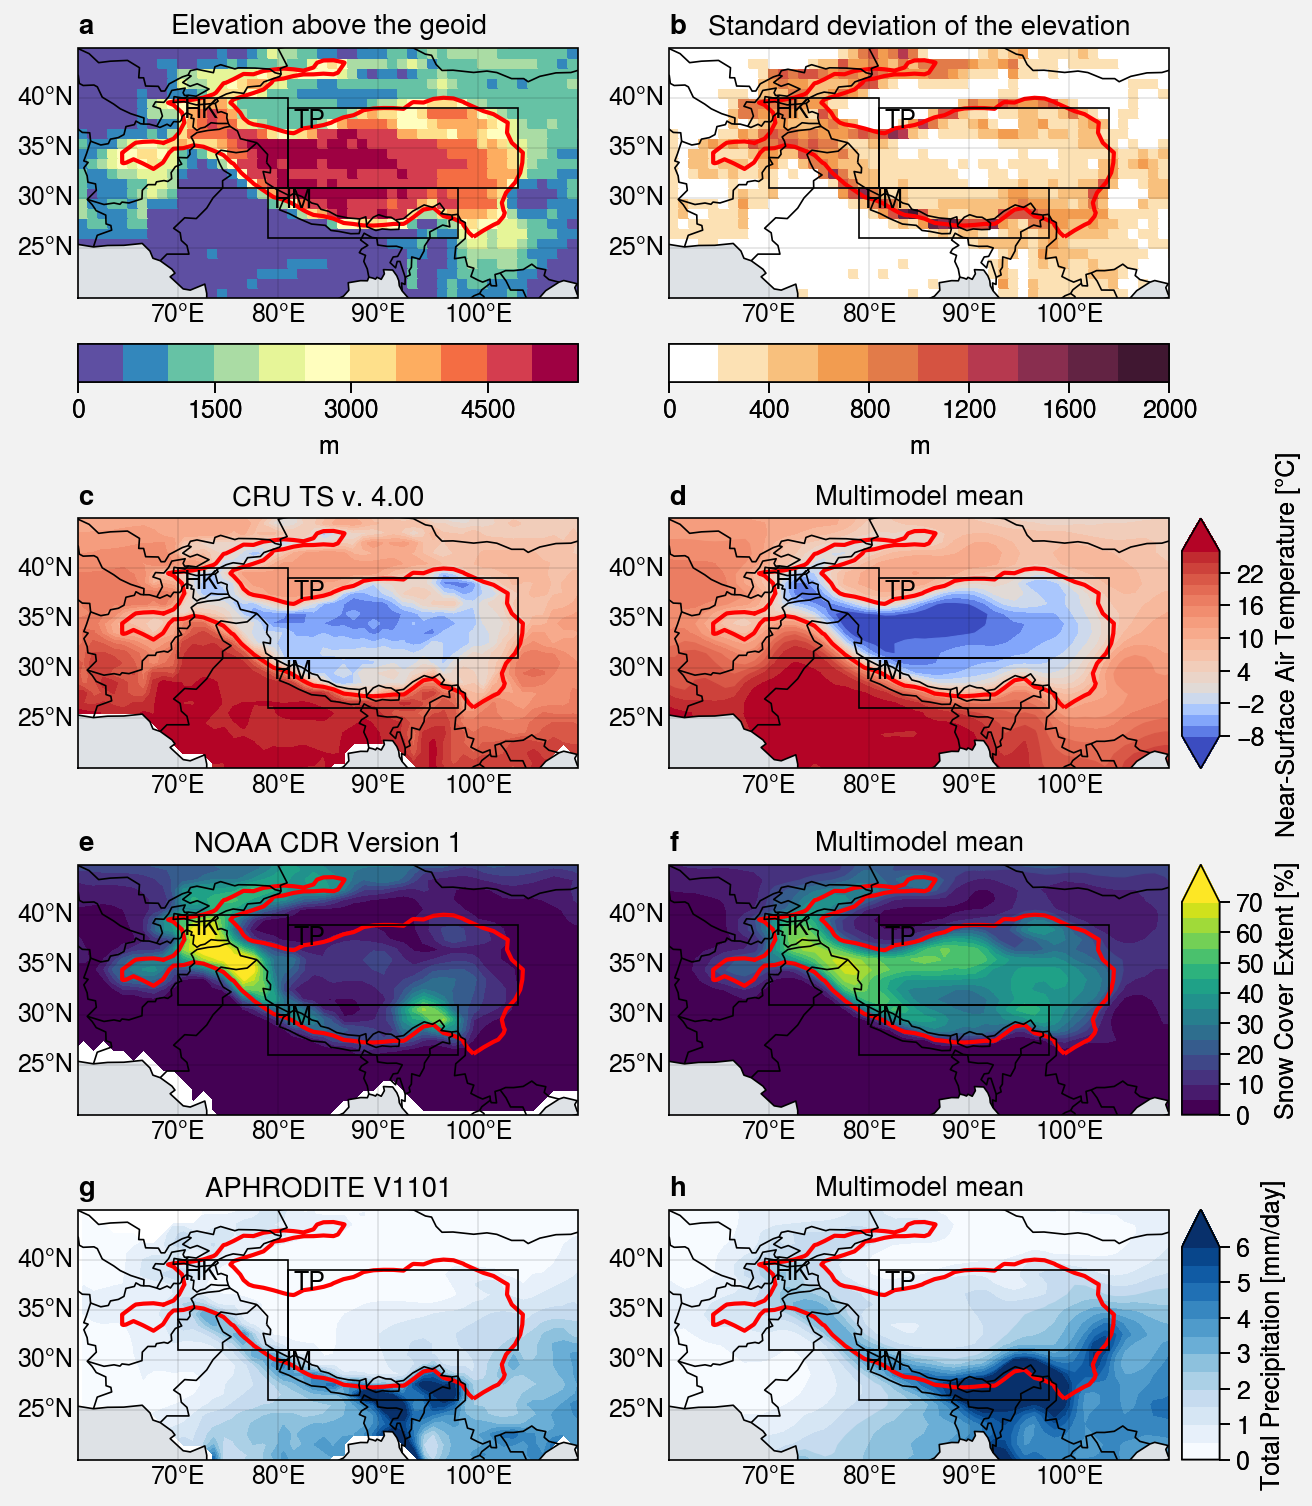

In [12]:
f, axs = plot.subplots(proj='cyl', ncols=2, nrows=4)

# Elevation
m0 = axs[0].pcolormesh(elevation, cmap='Spectral_r')
axs[0].colorbar(m0, label='m', loc='b')

# STD
m1 = axs[1].pcolormesh(elevation_std)
axs[1].colorbar(m1, label='m', loc='b')

# tas, snc, pr
cmap_list = ['CoolWarm', 'viridis', 'Blues']
levels_list = [plot.arange(-8,26,2), plot.arange(0,70,5), plot.arange(0,6,0.5)]
extend_list = ['both', 'max', 'max']
norm_list = [plot.Norm('diverging', fair=False), None, None]

k = 2
for i, var in enumerate(var_list):
    
    label, units, levels, cmap, extend, \
        levels_diff, cmap_diff, extend_diff, \
        levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
    
    # Obs
    axs[k].contourf(obs_clim.sel(season='Annual', var=var), cmap=cmap_list[i], levels=levels_list[i], extend=extend_list[i], norm=norm_list[i])
    k += 1
    
    # Model
    m = axs[k].contourf(multimodel_clim.sel(season='Annual', var=var).mean('model'), cmap=cmap_list[i], levels=levels_list[i], extend=extend_list[i], norm=norm_list[i])
    axs[k].colorbar(m, label=label+' ['+units+']')
    k += 1


# Plot zones
for ax in axs:
    u.plot_zones(ax)
    ax.contour(elevation, levels=[2500], color='red')
    ax.format(title='')

# Format
axs.format(
    # Grids, labels and limits
    labels=True, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=True,
)

for ax, title in zip(axs, [
    'Elevation above the geoid', 'Standard deviation of the elevation',
    'CRU TS v. 4.00', 'Multimodel mean',
    'NOAA CDR Version 1', 'Multimodel mean',
    'APHRODITE V1101', 'Multimodel mean',
]):
    ax.format(title=title)


# Save
filename = 'fig1_topo-cllim_'+period.start+'-'+period.stop
f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

## Spatial correlations

In [16]:
for i, var in enumerate(var_list):
    print(var)
    x = obs_clim.sel(season='Annual', var=var).where(elevation > 2500).values.flatten()
    y = multimodel_clim.sel(season='Annual', var=var).mean('model').where(elevation > 2500).values.flatten()
    
    # Remove NaNs
    if len(x) <= len(y):
        temp = x
    else:
        temp = y
    x = x[~np.isnan(temp)]
    y = y[~np.isnan(temp)]
    
    print(stats.linregress(x, y))

tas
LinregressResult(slope=0.9640764678755954, intercept=-1.7876213695841274, rvalue=0.8563907953514791, pvalue=4.5604260561928237e-101, stderr=0.031293618635118724)
snc
LinregressResult(slope=0.3054787319316153, intercept=28.53325464768602, rvalue=0.4686745486671663, pvalue=2.381625331561378e-20, stderr=0.030998676801901954)
pr
LinregressResult(slope=1.6794958642276852, intercept=0.7426589416188996, rvalue=0.7812138318698674, pvalue=1.383874410474702e-72, stderr=0.07225492050174555)


In [ ]:
multimodel_clim.sel(season='Annual', var=var).mean('model')

In [ ]:
x = bias[pair[0]].sel(season=season, model=model).where(elevation > 2500).values.flatten()

if pair[1] == 3:
    y = elevation.sel(lat=latlim, lon=lonlim).where(elevation > 2500).values.flatten()
else:
    y = bias[pair[1]].sel(season=season, model=model).where(elevation > 2500).values.flatten()

# Remove the nans
#             print(len(x))
#             print(len(y))
if len(x) <= len(y):
    temp = x
else:
    temp = y
x = x[~np.isnan(temp)]
y = y[~np.isnan(temp)]

# Get rvalue
df.loc[season, corr_labels[k]][model] = stats.linregress(x, y).rvalue
df_pvalue.loc[season, corr_labels[k]][model] = stats.linregress(x, y).pvalue